### Predicting Solana Price with Python and Machine Learning using Tensorflow and Keras and LSTM and SARIMA

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('solana_2020-04-09_2024-10-22.csv')

# Sort data by the 'Start' date
data = data.sort_values('Start')

# Select relevant features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert the scaled features into a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# Display the first few rows of the scaled data
print(scaled_data.head())






       Open      High       Low     Close    Volume
0  0.000579  0.000714  0.000339  0.000649  0.000025
1  0.000674  0.002858  0.000431  0.001647  0.001460
2  0.001680  0.001893  0.001078  0.000989  0.002984
3  0.001055  0.001543  0.001058  0.001452  0.001555
4  0.001418  0.001236  0.001110  0.000987  0.001034


### Create Sequences for LSTM

In [2]:
import numpy as np

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length, 3]  # Assuming 'Close' is the target
        sequences.append((sequence, target))
    return sequences

sequence_length = 60  # Example sequence length
sequences = create_sequences(scaled_features, sequence_length)

# Split into training and testing sets
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

# Prepare the data for the LSTM model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])


### Build and Train the LSTM Model


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0241 - val_loss: 1.5322e-04
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0035 - val_loss: 1.3885e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0032 - val_loss: 1.3691e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0030 - val_loss: 1.9049e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0031 - val_loss: 1.5501e-04
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 3.5839e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0023 - val_loss: 7.2610e-04
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0027 - val_loss: 1.1954e-04
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - val_loss: 1.2852e-04
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0019 - val_loss: 2.5594e-04
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0019 - val_loss: 8.5596e-05
Epoch 12/20
32/32 ━

In [4]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Loss: {loss * 100}%')





10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
Test Loss: 0.0015148217789828777
Test Loss: 0.15148217789828777%


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


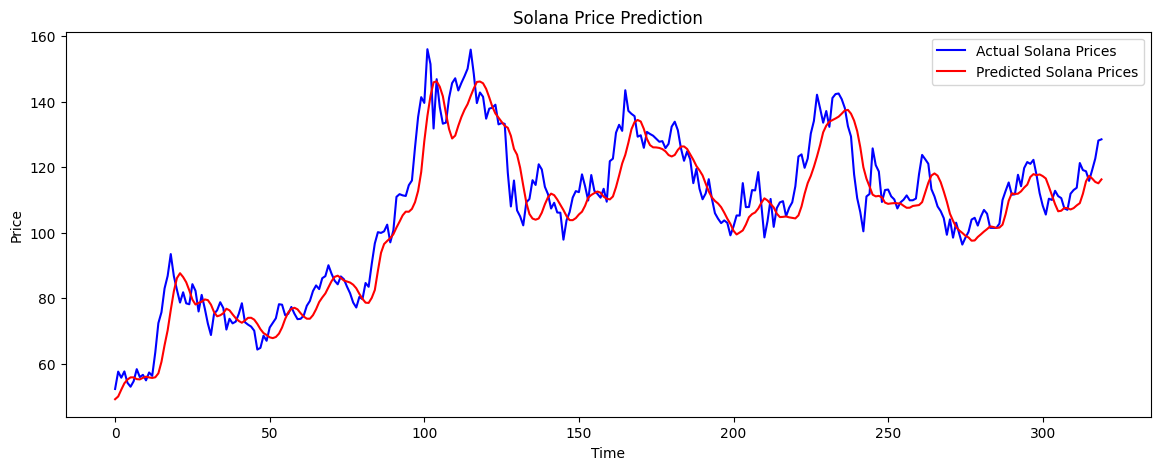

In [5]:
# Make predictions
predictions = model.predict(X_test)


# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Solana Prices')
plt.plot(predicted_prices, color='red', label='Predicted Solana Prices')
plt.title('Solana Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Save the Model

In [6]:
model.save('solana_price_prediction_lstm.keras')


## Load model

In [7]:
from tensorflow.keras.models import load_model

model = load_model('solana_price_prediction_lstm.keras')


### Early Stopping: To stop training when the model stops improving.
### Learning Rate Scheduler: To adjust the learning rate during training.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Create a new optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model



### Train the model with early stopping:

In [9]:
# Create the model
model = create_model()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - loss: 0.0243 - val_loss: 1.9454e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0030 - val_loss: 1.2581e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0026 - val_loss: 2.3024e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0023 - val_loss: 1.6810e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0022 - val_loss: 2.1350e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0020 - val_loss: 1.2339e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0022 - val_loss: 2.2308e-04
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 3.1601e-04
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0024 - val_loss: 1.4843e-04
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0025 - val_loss: 9.2042e-05
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0019 - val_loss: 1.1069e-04
Epoch 12/100
32/32

### Hyperparameter Tuning

In [10]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Choose an optimal learning rate between 0.01 and 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error')
    
    return model

tuner = kt.Hyperband(model_builder,
                    objective='val_loss',
                    max_epochs=20,
                    factor=3,
                    directory='my_dir',
                    project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)


C:\Users\Student\AppData\Local\Temp\ipykernel_9100\214373872.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from my_dir\intro_to_kt\tuner0.json
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0248 - val_loss: 1.5512e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 962ms/step - loss: 0.0014 - val_loss: 7.2481e-05
Epoch 3/50


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.0010 - val_loss: 2.2068e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 898ms/step - loss: 0.0019 - val_loss: 2.1590e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 994ms/step - loss: 0.0014 - val_loss: 1.2374e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 789ms/step - loss: 0.0012 - val_loss: 6.8574e-05
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 785ms/step - loss: 0.0011 - val_loss: 9.0172e-05
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 862ms/step - loss: 8.9206e-04 - val_loss: 1.3143e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 826ms/step - loss: 9.1927e-04 - val_loss: 7.3003e-05
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 732ms/step - loss: 8.1637e-04 - val_loss: 7.7228e-05
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 746ms/step - loss: 9.5982e-04 - val_loss: 1.4130e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 739ms/step - loss: 9.3806e-04 - val_loss: 9.1989e-05
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 667ms/step - loss: 0.0010 - val_loss: 

# Model Architecture Visualization

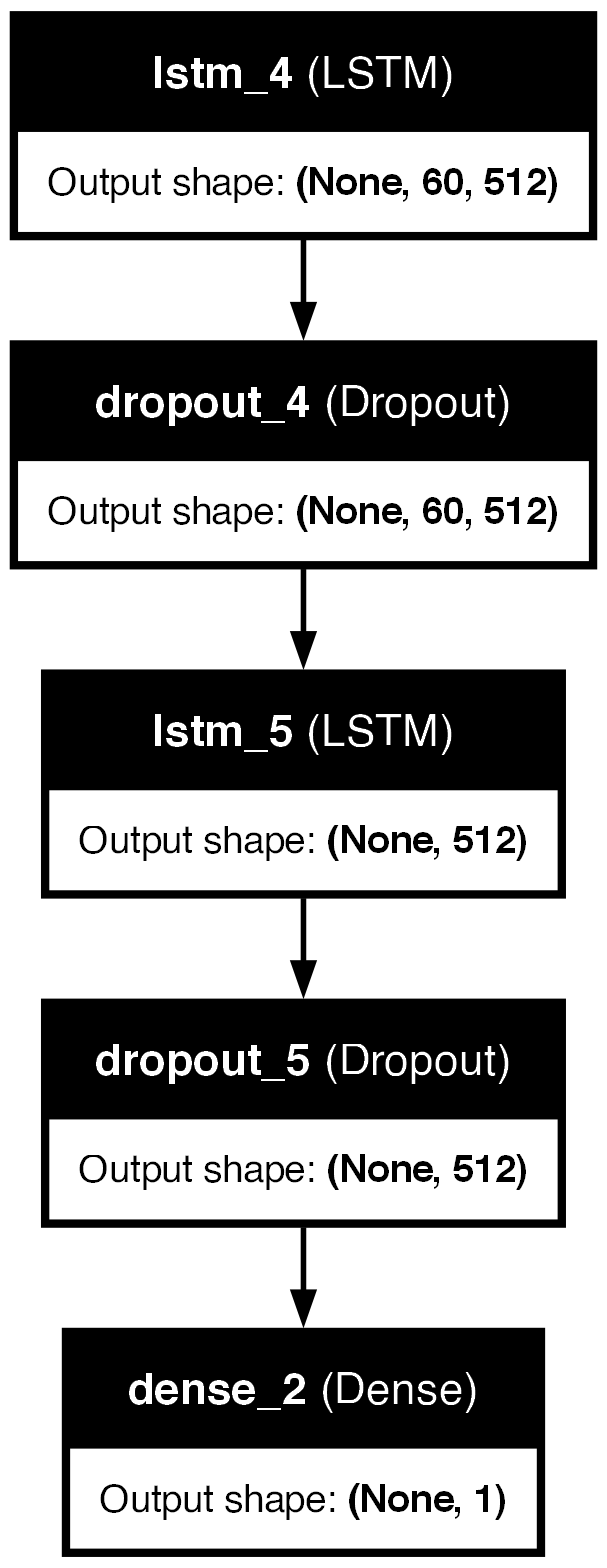

In [11]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


# Training History Visualization

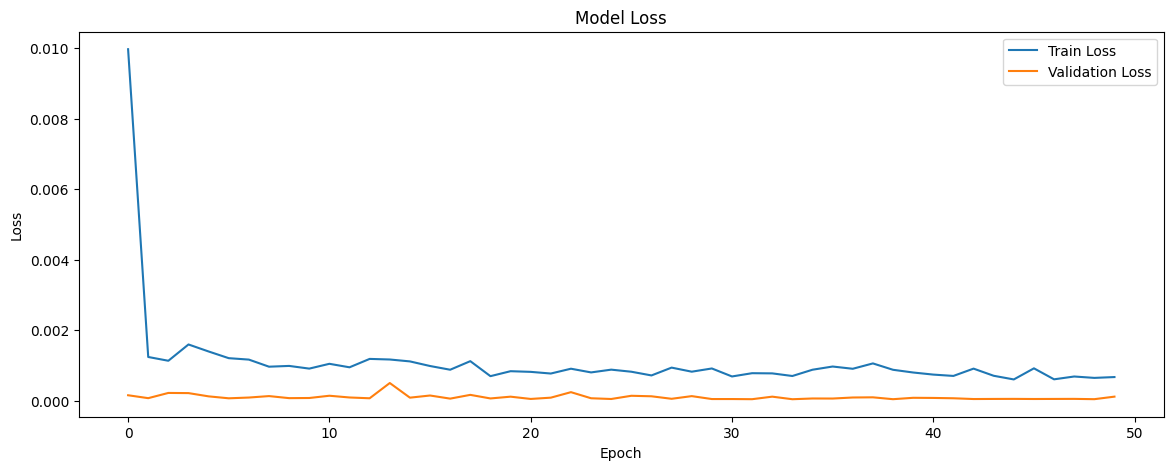

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Prediction Visualization

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step


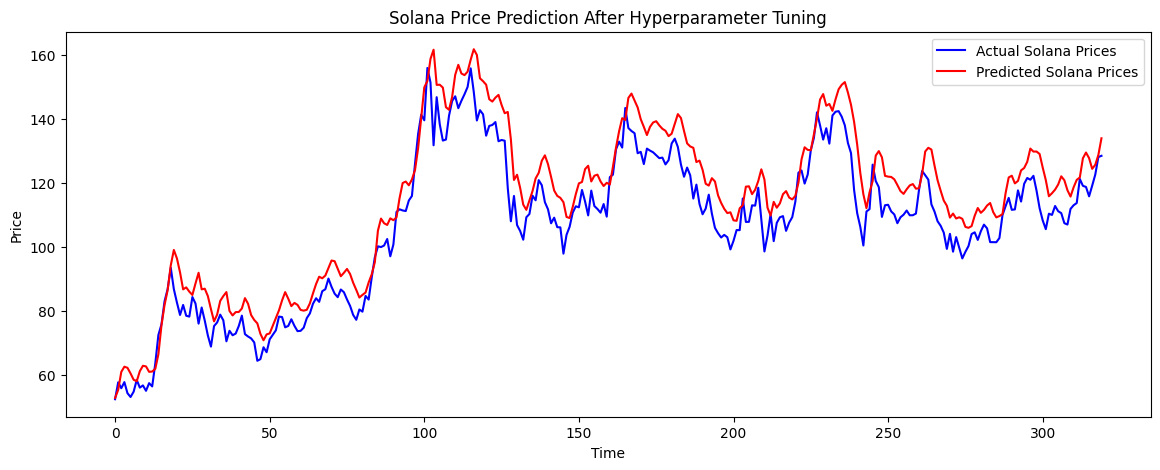

In [13]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Solana Prices')
plt.plot(predicted_prices, color='red', label='Predicted Solana Prices')
plt.title('Solana Price Prediction After Hyperparameter Tuning')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Assuming X_test and y_test are already defined and you have a trained model

# Make predictions on the test set
y_pred = model.predict(X_test)

# If you used a MinMaxScaler or any other scaler on your y values, you'll need to inverse transform
# Assuming you used a MinMaxScaler called scaler_y to scale your y values:
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Flatten the predictions and actual values if they have more than 1 dimension
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse}")
print(f"Mean Squared Error Percentage: {mse * 100:.2f}%")


# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
rmse_percentage = (rmse / max(y_test)) * 100
#print(f"Root Mean Squared Error: {rmse}")
print(f"Root Mean Squared Error (RMSE): {rmse_percentage:.2f}%")

# Calculate Mean Absolute Error (MAE)
mae = sum(abs(y_test - y_pred)) / len(y_test)
mae_percentage = (mae / max(y_test)) * 100
#print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Error (MAE): {mae_percentage:.2f}%")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
# print(f"R-squared: {r2}")
print(f"R-squared Percentage: {r2 * 100:.2f}%")

# If you want an accuracy score (though typically not used in regression)
# Define an accuracy metric, e.g., percentage of predictions within a certain threshold of actual value
accuracy = np.mean(np.abs(y_test - y_pred) <= 0.1 * y_test) * 100
print(f"Accuracy: {accuracy}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step
Mean Squared Error Percentage: 0.22%
Root Mean Squared Error (RMSE): 5.95%
Mean Absolute Error (MAE): 5.07%
R-squared Percentage: 83.86%
Accuracy: 72.5%


# Feature Engineering

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('solana_2020-04-09_2024-10-22.csv')

# 1. Simple Moving Average (SMA)
data['SMA_7'] = data['Close'].rolling(window=7).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# 2. Relative Strength Index (RSI)
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data['Close'])

# 3. Moving Average Convergence Divergence (MACD and Signal Line)
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 4. Standard Deviation (volatility measure)
data['STD'] = data['Close'].rolling(window=21).std()

# 5. Bollinger Bands (Upper and Lower)
data['Bollinger_Upper'] = data['SMA_30'] + (data['STD'] * 2)
data['Bollinger_Lower'] = data['SMA_30'] - (data['STD'] * 2)

# 6. Rate of Change (ROC)
data['ROC'] = data['Close'].pct_change(periods=5) * 100

# Drop any rows with NaN values created by rolling calculations
data.dropna(inplace=True)

# Save the enhanced dataset with technical indicators to a CSV file
data.to_csv('solana_with_technical_indicators.csv', index=False)

# Preview the first few rows of the dataset
print(data.head())


         Start         End        Open        High         Low       Close  \
29  2024-09-22  2024-09-23  115.280283  115.373390  108.960270  111.582275   
30  2024-09-21  2024-09-22  112.767249  115.320868  111.516815  115.320868   
31  2024-09-20  2024-09-21  110.274006  116.941263  108.900124  112.737368   
32  2024-09-19  2024-09-20  103.844868  110.831800  103.789728  109.957490   
33  2024-09-18  2024-09-19  101.467682  102.750229   98.216571  102.750229   

          Volume    Market Cap       SMA_7      SMA_30        RSI      MACD  \
29  6.010073e+09  5.258095e+10  116.770078  115.471599  48.625720 -1.175962   
30  9.037421e+09  5.313249e+10  115.959457  115.032496  56.006634 -1.067290   
31  1.255769e+10  5.317793e+10  114.700156  114.519785  52.545426 -1.176077   
32  1.118641e+10  5.055809e+10  113.304854  114.097625  54.973879 -1.469663   
33  7.078255e+09  4.706470e+10  111.674491  113.551242  44.376974 -2.257870   

    MACD_Signal       STD  Bollinger_Upper  Bollinger_Lo

# SARIMA Integration

c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa

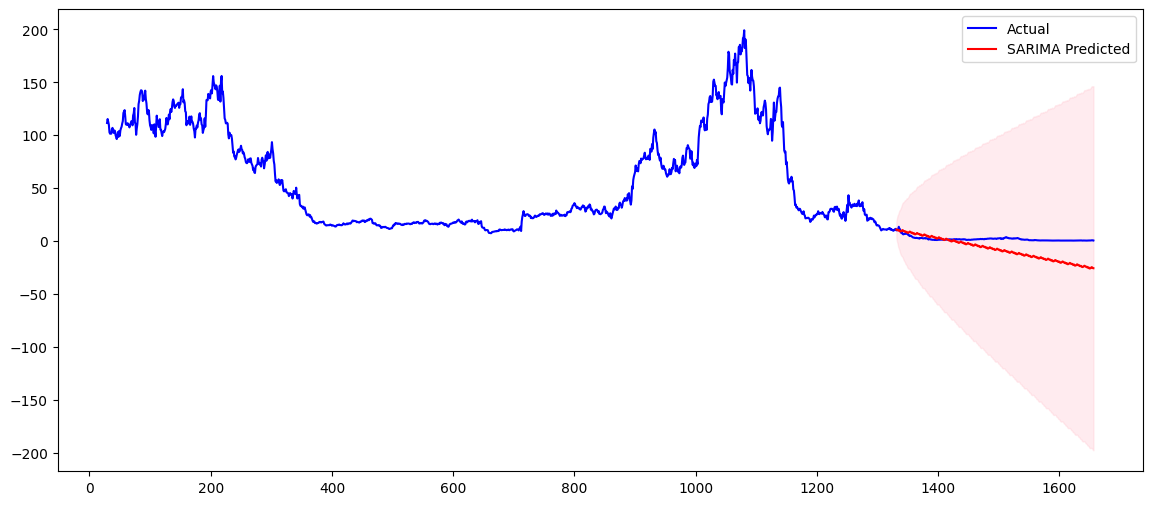

ValueError: Must have equal len keys and value when setting with an iterable

In [4]:
# Imported libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data['Close'][:train_size], data['Close'][train_size:]

# Define SARIMA model (tune parameters as needed)
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_fitted = sarima_model.fit(disp=False)

# Make predictions
sarima_forecast = sarima_fitted.get_prediction(start=train_size, end=len(data)-1)
sarima_predictions = sarima_forecast.predicted_mean

# Plot SARIMA predictions
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], color='blue', label='Actual')
plt.plot(data.index[train_size:], sarima_predictions, label='SARIMA Predicted', color='red')
plt.fill_between(data.index[train_size:], sarima_forecast.conf_int().iloc[:, 0], sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

# Add SARIMA predictions to the dataset for later use in ensemble
data['SARIMA_Pred'] = np.nan
data.loc[train_size:, 'SARIMA_Pred'] = sarima_predictions.values

# Enhancing LSTM Architecture

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model with residual connections
model = Sequential()

# LSTM layers with residual connections
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layers for final prediction
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Predict
lstm_predictions = model.predict(X_test)


NameError: name 'X_train' is not defined